40/40 [==============================] - 1s 14ms/step


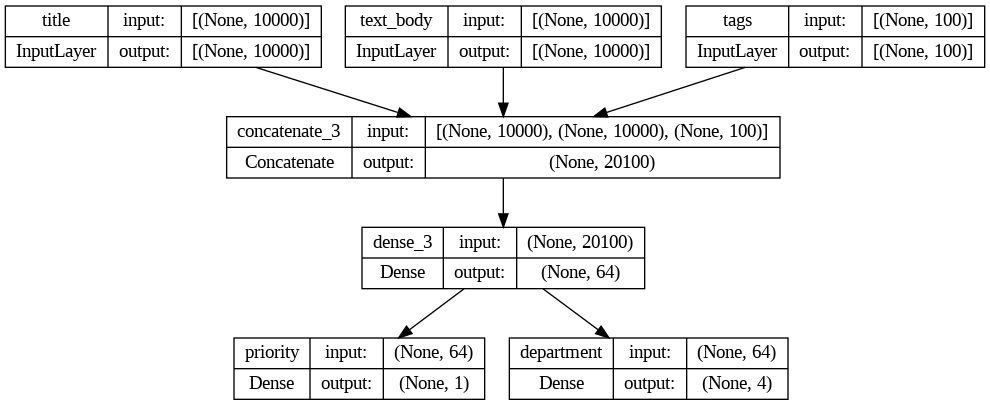

In [10]:
import numpy as np
from tensorflow import keras
from keras import layers

vocabulary_size = 10000
num_tags = 100
num_departments = 4

title = keras.Input(shape=(vocabulary_size,), name="title")
text_body = keras.Input(shape=(vocabulary_size,), name="text_body")
tags = keras.Input(shape=(num_tags,), name="tags")

# above are the 3 model inputs. We create them each as a input layer
concatenate = layers.Concatenate()([title, text_body, tags])
features = layers.Dense(units=64, activation="relu")(concatenate)
# we then combine input features into a single tensor, features, by concatenating them

# our model has 2 ouputs
priority = layers.Dense(1, activation="sigmoid", name="priority")(features)
department = layers.Dense(num_departments, activation="softmax", name="department")(features)

# now, declare the model
model = keras.Model(inputs=[title, text_body, tags],
                       outputs=[priority, department])


num_samples = 1280

# create some dummy input data
title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))

# create corresponding dummy targets
priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))

model.compile(optimizer="rmsprop",loss=["mean_squared_error", "categorical_crossentropy"], metrics=[["mean_absolute_error"], ["accuracy"]])

model.fit([title_data, text_body_data, tags_data], [priority_data, department_data], epochs=1)

model.evaluate([title_data, text_body_data, tags_data],[priority_data, department_data])
priority_preds, department_preds = model.predict([title_data, text_body_data, tags_data])

keras.utils.plot_model(model, "ticket_classifier.png", show_shapes=True)

In [ ]:
'''
This is example of subclassing Model.Keras but without defining custom training functions
'''
class CustomerTicketModel(keras.Model):
  def __init__(self, num_departments):
    super().__init__()
    self.concat_layer = layers.Concatenate()
    self.mixing_layer = layers.Dense(64, activation="relu")
    self.priority_scorer = layers.Dense(1, activation="sigmoid")
    self.department_classifier = layers.Dense(
                num_departments, activation="softmax")

  def call(self, inputs):
    title = inputs["title"]
    text_body = inputs["text_body"]
    tags = inputs["tags"]

    features = self.concat_layer([title, text_body, tags])
    features = self.mixing_layer(features)

    priority = self.priority_scorer(features)
    department = self.department_classifier(features)

    return priority, department

model = CustomerTicketModel(num_departments=4)
# below is computing a forward pass of inputs through the model 
'''
priority, department = model(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data})
'''

# the object we pass to the model must be the same as `inputs` from the call method

model.compile(optimizer="rmsprop", loss=["mean_squared_error", "categorical_crossentropy"], metrics=[["mean_absolute_error"], ["accuracy"]])

# training data 
model.fit({"title": title_data, "text_body": text_body_data,
"tags": tags_data}, [priority_data, department_data], epochs=1)

# validation data / test data 
model.evaluate({"title": title_data, "text_body": text_body_data,
"tags": tags_data}, [priority_data, department_data])

# new unseen data (could be test data if the above is on validation data)
priority_preds, department_preds = model.predict({"title": title_data,
                                                  "text_body": text_body_data, "tags": tags_data})

# The structure of the input data must match exactly what is expected by the call() method — here, a dict with keys title, text_body, and tags.